In [ ]:
from google.colab import files
uploaded = files.upload()

Saving prices.csv to prices (1).csv
Saving prices-split-adjusted.csv to prices-split-adjusted (1).csv
Saving securities.csv to securities (1).csv
Saving fundamentals.csv to fundamentals (1).csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Load the dataset
df = pd.read_csv("prices.csv")
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])
df = df.sort_values(["symbol", "date"])
df.head()

,date,symbol,open,close,low,high,volume
717,2010-01-04,AIV,16.150000,15.960000,15.810000,16.350000,1938700.0
1185,2010-01-05,AIV,16.070000,16.360001,15.890000,16.370001,2070700.0
1653,2010-01-06,AIV,16.360001,16.650000,16.360001,16.889999,3797300.0
2121,2010-01-07,AIV,16.590000,17.260000,16.430000,17.360001,3902600.0
2589,2010-01-08,AIV,17.100000,16.860001,16.600000,17.209999,3825200.0


In [ ]:
# Add symbol encoding
le = LabelEncoder()
df["symbol_id"] = le.fit_transform(df["symbol"])
df.head()

,date,symbol,open,close,low,high,volume,symbol_id
717,2010-01-04,AIV,16.150000,15.960000,15.810000,16.350000,1938700.0,0
1185,2010-01-05,AIV,16.070000,16.360001,15.890000,16.370001,2070700.0,0
1653,2010-01-06,AIV,16.360001,16.650000,16.360001,16.889999,3797300.0,0
2121,2010-01-07,AIV,16.590000,17.260000,16.430000,17.360001,3902600.0,0
2589,2010-01-08,AIV,17.100000,16.860001,16.600000,17.209999,3825200.0,0


In [ ]:
# Select features + target
features = ["open", "high", "low", "volume", "symbol_id"]
X = df[features].values
y = df["close"].values.reshape(-1, 1)

In [ ]:
# Chronological split (We split based on date, NOT randomly)
split_date = df["date"].quantile(0.8)   # 80% for training, 20% for testing

train_df = df[df["date"] <= split_date]
test_df  = df[df["date"] >  split_date]

X_train = train_df[features].values
y_train = train_df["close"].values.reshape(-1,1)

X_test  = test_df[features].values
y_test  = test_df["close"].values.reshape(-1,1)

print(len(X_train), len(X_test))

1711 428


In [ ]:
# Proper normalization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Numerical columns: open, high, low, volume
X_train_num = scaler_X.fit_transform(X_train[:, :4])
X_test_num  = scaler_X.transform(X_test[:, :4])

# Symbol ID stays as integer (embedding-like effect)
X_train_sym = X_train[:, 4].reshape(-1,1)
X_test_sym  = X_test[:, 4].reshape(-1,1)

# Combine normalized numerical + raw symbol_id
X_train_scaled = np.hstack([X_train_num, X_train_sym])
X_test_scaled  = np.hstack([X_test_num,  X_test_sym])

# Scale target y
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled  = scaler_y.transform(y_test)

In [ ]:
# Convert to tensors + DataLoader
X_train_t = torch.FloatTensor(X_train_scaled).to(device)
y_train_t = torch.FloatTensor(y_train_scaled).to(device)

X_test_t = torch.FloatTensor(X_test_scaled).to(device)
y_test_t = torch.FloatTensor(y_test_scaled).to(device)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=128, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=256, shuffle=False)


In [ ]:
# Regression Model
class RegressionDNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
# Training Loop + Loss Curves
model = RegressionDNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

train_losses = []
test_losses = []
epochs = 80

for epoch in range(epochs):
    model.train()
    batch_losses = []

    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    train_losses.append(np.mean(batch_losses))

    # Evaluate test loss
    model.eval()
    val_losses = []
    with torch.no_grad():
        for Xb, yb in test_loader:
            pred = model(Xb)
            val_losses.append(criterion(pred, yb).item())

    test_losses.append(np.mean(val_losses))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train={train_losses[-1]:.4f}, Test={test_losses[-1]:.4f}")


Epoch 0: Train=0.7688, Test=3.8035
Epoch 10: Train=0.0088, Test=0.0096
Epoch 20: Train=0.0096, Test=0.0081
Epoch 30: Train=0.0083, Test=0.0138
Epoch 40: Train=0.0072, Test=0.0300
Epoch 50: Train=0.0060, Test=0.0738
Epoch 60: Train=0.0066, Test=0.0345
Epoch 70: Train=0.0059, Test=0.0233


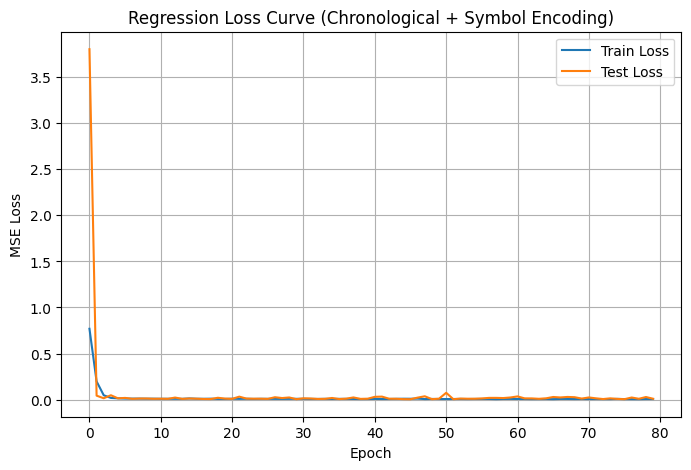

In [ ]:
# Plot clean loss curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Regression Loss Curve (Chronological + Symbol Encoding)")
plt.legend()
plt.grid()
plt.show()